# Job Postings Analysis using LatentDirichletAllocation (LDA)

What the job market for tech industry looks like during the pandemic? Covid-19 poses unparalled challenges for the US economy. How do tech companies deal with hiring during the pandemic? We'll analyze job postings from Indeed to see how the pandemic affects the job market in some states in the U.S, thereby making recommendations for job seekers to strategically get their dream jobs.

Employers also benefit from this analysis service as it provides them an estimate of latent trends in the hiring practices of the tech industry.

Indeed Example:

[CCDC Army Research](https://www.indeed.com/viewjob?jk=936144a8b2b5acd1&tk=1efgthc3tp2nn800&from=serp&vjs=3)

[Healthcare Data Analyst](https://www.indeed.com/viewjob?cmp=Fix-Healthcare-Technology%2C-LLC&t=Senior+Healthcare+Data+Analyst&jk=8fc686850a111800&sjdu=QwrRXKrqZ3CNX5W-O9jEvUUdXQhhKNOAMcM5flKILojutC2w3UfT7WyHomKZkXPmMSP1u4KyaFgIlFr0ct83SlAtyIJp_QRNFvHsIHisu7A&tk=1efgthc3tp2nn800&adid=358180655&pub=4a1b367933fd867b19b072952f68dceb&vjs=3)

In [4]:
# Common Package
import re, sys
import pandas as pd
import numpy as np

from pathlib import Path
pd.set_option('mode.chained_assignment', None)

from typing import List, Callable
from ipywidgets import widgets
from config import CONFIG


# NLP&ML package
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
parent_cwd = Path.cwd().parent
sys.path.append(str(parent_cwd))
import src.features.text_normalize as tn

# Plotting
import matplotlib.pyplot as plt
# import plotly
%matplotlib inline

In [2]:
# Read in data
# downloaded from Indeed
jobInfo = pd.read_csv('../data/raw/jobpostsRaw.csv')
# jobDesc = pd.read_csv('data/JobDesc.csv')

In [5]:
# Number of job postings
jobInfo.shape

(487, 4)

In [8]:
jobInfo.head(3)

,title,summarylinks,name,location
0,\nSummer College Intern - Data Scientist (Gas ...,/rc/clk?jk=56f8c27d1c3d317d&fccid=ee1723cae957...,\n\nNextEra Energy,"Houston, TX 77002 (Downtown area)"
1,\nStrategic Analytics – Data Scientist,/rc/clk?jk=dc292d195e42d954&fccid=9e215d88a6b3...,\n\nDeloitte,"Houston, TX 77002 (Downtown area)"
2,\nData Scientist,/rc/clk?jk=57c74ab117738d77&fccid=2fe5bdb74ccd...,\n\nCGG,"Houston, TX"


In [9]:
titles = ['data scientist', 'data analyst', 'machine learning engineer', 'software engineer','data engineer']

In [10]:
# Extracting job title information from job description
patternds = re.compile(r'data\s(scientist|science)')
patternda = re.compile(r'analyst')
patternml = re.compile(r'(nlp|machine|deep)\slearning')
patternse = re.compile(r'software\s(engineer|developer)')
patternde = re.compile(r'data\slearning')
test = 'data scientist - production research'
ds = []
da = []
de = []
ml = []
se = []
others = []
for idx, val in enumerate(jobInfo.title.str.lower()):
    if re.search(patternds, val):
        ds.append(idx)
    elif re.search(patternda, val):
        da.append(idx)
    elif re.search(patternde, val):
        de.append(idx)
    elif re.search(patternml, val):
        ml.append(idx)
    elif re.search(patternse, val):
        se.append(idx)
    else:
        others.append(idx)


In [11]:
jobInfo['job_title'] = None
jobInfo.iloc[ds,-1] = 'data science'
jobInfo.iloc[da,-1] = 'data analyst'
jobInfo.iloc[se,-1] = 'software engineer'
jobInfo.iloc[ml,-1] = 'machine learning'
jobInfo.iloc[de,-1] = 'data engineer'
jobInfo.job_title.fillna('Other', inplace=True)
jobInfo.job_title.unique()

array([&#39;data science&#39;, &#39;Other&#39;, &#39;data analyst&#39;, &#39;software engineer&#39;,
       &#39;machine learning&#39;], dtype=object)

In [12]:
# Job info
jobInfo.summarylinks = 'https://www.indeed.com' + jobInfo['summarylinks']
display(jobInfo.head(3))

,title,summarylinks,name,location,job_title
0,\nSummer College Intern - Data Scientist (Gas ...,https://www.indeed.com/rc/clk?jk=56f8c27d1c3d3...,\n\nNextEra Energy,"Houston, TX 77002 (Downtown area)",data science
1,\nStrategic Analytics – Data Scientist,https://www.indeed.com/rc/clk?jk=dc292d195e42d...,\n\nDeloitte,"Houston, TX 77002 (Downtown area)",data science
2,\nData Scientist,https://www.indeed.com/rc/clk?jk=57c74ab117738...,\n\nCGG,"Houston, TX",data science


In [216]:
# Merge dataframes
mergedDf = jobInfo.merge(jobDesc, left_on='summarylinks', right_on='links')
mergedDf.drop(['Unnamed: 0_y', 'links', 'Unnamed: 0_x'], axis=1, inplace=True)
mergedDf.head(2)

,title,summarylinks,name,location,job_title,description
0,Data Scientist,https://www.indeed.com/company/GradTests/jobs/Data-Scientist-cb83495bc53e4cd0?fccid=3b57c72e54f9233d&vjs=3,GradTests (gradtests.com),"Houston, TX",data science,"The BusinessGradTests.com is a leading provider of practice psychometric tests to graduates, students and young professionals.The RoleA data science all rounder role. The core purpose of the role ..."
1,Data Scientist - Production Research,https://www.indeed.com/rc/clk?jk=bddcb1faeb174b60&fccid=3c78581902185d47&vjs=3,"RiceTec, Inc.","Alvin, TX",data science,The RiceTec Data Scientist will need to Design strategies and implement algorithms to analyze and leverage data; assessing the effectiveness and accuracy of data sources to be used as inputs in da...


## New Tech Jobs by State

We'll analyze the current job market by state in tech industry. Before we start the analysis, we'll extract the location of each job post from Google Map using its full address.

In [190]:
with open('keys.txt', 'r') as f:
    API_Key = f.read()

In [16]:
from geopy.geocoders import Nominatim, GoogleV3 
geolocator = GoogleV3(api_key=API_Key)

In [18]:
# Getting coordinates from GoogleMap using full address
def assign_coor(data:pd.DataFrame, col:str) -> None:
    data['loc'] = None
    for idx, val in enumerate(data[col]):
        try:
            data['loc'].iloc[idx] = geolocator.geocode(val)
        except:
            data['loc'].iloc[idx] = None
assign_coor(mergedDf, col='location')

In [26]:
mergedDf.head()

,title,summarylinks,name,location,job_title,description,loc
0,Data Scientist,https://www.indeed.com/company/GradTests/jobs/...,GradTests (gradtests.com),"Houston, TX",data science,The BusinessGradTests.com is a leading provide...,"(Houston, TX, USA, (29.7604267, -95.3698028))"
1,Data Scientist - Production Research,https://www.indeed.com/rc/clk?jk=bddcb1faeb174...,"RiceTec, Inc.","Alvin, TX",data science,The RiceTec Data Scientist will need to Design...,"(Alvin, TX, USA, (29.4238472, -95.244100899999..."
2,Data Scientist,https://www.indeed.com/rc/clk?jk=920503f4cad6e...,Tokio Marine HCC,"Houston, TX 77040 (Fairbanks - Northwest Cross...",data science,Tokio Marine HCC is a leading specialty insura...,"(Fairbanks / Northwest Crossing, Houston, TX, ..."
3,Data Scientist,https://www.indeed.com/rc/clk?jk=1e8835abdc7df...,Techwave Consulting Inc.,"Houston, TX 77077",data science,Data Scientist – North America CoE\nThe Data S...,"(Houston, TX 77077, USA, (29.7451163, -95.6195..."
4,Software Developer Intern (Data Analytics Team...,https://www.indeed.com/rc/clk?jk=5087da22d7255...,BDO,"Houston, TX 77019 (Neartown - Montrose area)",software engineer,Houston\nTexas\n18081BR\nJob Summary\nBDO’s Co...,"(Montrose, Houston, TX, USA, (29.742668, -95.3..."


In [ ]:
# mergedDf.to_csv('data/Updated_JobInfo.csv', index=False)

In [32]:
# Extract coordinates into separate columns
mergedDf["point"]= mergedDf["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

In [35]:
mergedDf[['lat', 'lon', 'altitude']] = pd.DataFrame(mergedDf['point'].to_list(), index=mergedDf.index)

In [37]:
mergedDf.to_csv('data/Updated_JobInfo.csv')
mergedDf = pd.read_csv('data/Updated_JobInfo.csv')
mergedDf.head()

,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude
0,Data Scientist,https://www.indeed.com/company/GradTests/jobs/...,GradTests (gradtests.com),"Houston, TX",data science,The BusinessGradTests.com is a leading provide...,"(Houston, TX, USA, (29.7604267, -95.3698028))","(29.7604267, -95.3698028, 0.0)",29.760427,-95.369803,0.0
1,Data Scientist - Production Research,https://www.indeed.com/rc/clk?jk=bddcb1faeb174...,"RiceTec, Inc.","Alvin, TX",data science,The RiceTec Data Scientist will need to Design...,"(Alvin, TX, USA, (29.4238472, -95.244100899999...","(29.4238472, -95.24410089999999, 0.0)",29.423847,-95.244101,0.0
2,Data Scientist,https://www.indeed.com/rc/clk?jk=920503f4cad6e...,Tokio Marine HCC,"Houston, TX 77040 (Fairbanks - Northwest Cross...",data science,Tokio Marine HCC is a leading specialty insura...,"(Fairbanks / Northwest Crossing, Houston, TX, ...","(29.8509122, -95.5154068, 0.0)",29.850912,-95.515407,0.0
3,Data Scientist,https://www.indeed.com/rc/clk?jk=1e8835abdc7df...,Techwave Consulting Inc.,"Houston, TX 77077",data science,Data Scientist – North America CoE\nThe Data S...,"(Houston, TX 77077, USA, (29.7451163, -95.6195...","(29.7451163, -95.61951119999999, 0.0)",29.745116,-95.619511,0.0
4,Software Developer Intern (Data Analytics Team...,https://www.indeed.com/rc/clk?jk=5087da22d7255...,BDO,"Houston, TX 77019 (Neartown - Montrose area)",software engineer,Houston\nTexas\n18081BR\nJob Summary\nBDO’s Co...,"(Montrose, Houston, TX, USA, (29.742668, -95.3...","(29.742668, -95.3991888, 0.0)",29.742668,-95.399189,0.0


In [220]:
mergedDf = pd.read_csv('data/Updated_JobInfo.csv')
mergedDf.drop(['Unnamed: 0'], axis=1, inplace=True)
mergedDf.head(2)

,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude
0,Data Scientist,https://www.indeed.com/company/GradTests/jobs/Data-Scientist-cb83495bc53e4cd0?fccid=3b57c72e54f9233d&vjs=3,GradTests (gradtests.com),"Houston, TX",data science,"The BusinessGradTests.com is a leading provider of practice psychometric tests to graduates, students and young professionals.The RoleA data science all rounder role. The core purpose of the role ...","Houston, TX, USA","(29.7604267, -95.3698028, 0.0)",29.76043,-95.36980,0.00000
1,Data Scientist - Production Research,https://www.indeed.com/rc/clk?jk=bddcb1faeb174b60&fccid=3c78581902185d47&vjs=3,"RiceTec, Inc.","Alvin, TX",data science,The RiceTec Data Scientist will need to Design strategies and implement algorithms to analyze and leverage data; assessing the effectiveness and accuracy of data sources to be used as inputs in da...,"Alvin, TX, USA","(29.4238472, -95.24410089999999, 0.0)",29.42385,-95.24410,0.00000


### Job Distribution by State

In [222]:
states = ['TX','NY','PA','CA','MA','DC']

def get_state(address:str):
    try:
        pattern = re.compile(r"(TX|NY|PA|CA|MA|DC)")
        return re.search(pattern, address).group()
    except Exception as e:
        pass

mergedDf['State'] = mergedDf['location'].apply(get_state)
mergedDf.head(2)

,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude,State
0,Data Scientist,https://www.indeed.com/company/GradTests/jobs/Data-Scientist-cb83495bc53e4cd0?fccid=3b57c72e54f9233d&vjs=3,GradTests (gradtests.com),"Houston, TX",data science,"The BusinessGradTests.com is a leading provider of practice psychometric tests to graduates, students and young professionals.The RoleA data science all rounder role. The core purpose of the role ...","Houston, TX, USA","(29.7604267, -95.3698028, 0.0)",29.76043,-95.36980,0.00000,TX
1,Data Scientist - Production Research,https://www.indeed.com/rc/clk?jk=bddcb1faeb174b60&fccid=3c78581902185d47&vjs=3,"RiceTec, Inc.","Alvin, TX",data science,The RiceTec Data Scientist will need to Design strategies and implement algorithms to analyze and leverage data; assessing the effectiveness and accuracy of data sources to be used as inputs in da...,"Alvin, TX, USA","(29.4238472, -95.24410089999999, 0.0)",29.42385,-95.24410,0.00000,TX


In [205]:
import plotly.express as px

# set up the chart from the df dataFrame
fig = px.scatter_geo(mergedDf,
                     locationmode = 'USA-states',
                     # longitude is taken from the df["lon"] columns and latitude from df["lat"]
                     lon="lon", 
                     lat="lat",
                     color="job_title",
                     # choose the map chart's projection
                     projection="natural earth",
                     # columns which is in bold in the pop up
                     hover_name = "location",
                     # format of the popup not to display these columns' data
                     hover_data = {"location":False,
                                   "lon": False,
                                   "lat": False
                                     }
                     )


# scatter_geo allow to change the map date based on the information from the df dataframe, but we can separately specify the values that are common to all
# change the size of the markers to 25 and color to red
fig.update_traces(marker=dict(size=15))

# fit the map to surround the points
fig.update_geos(fitbounds="locations")

# add title
fig.update_layout(
        title = 'Job Distribution By State'
    )
fig.show()

Text(0.5, 1.0, 'Job Distribution by States')

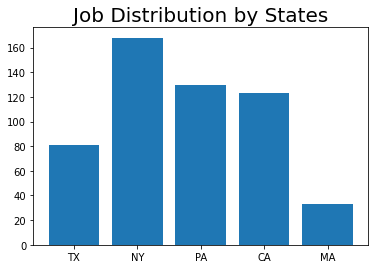

In [45]:
# Extracting index by State
locs = mergedDf.location.unique()
states = {'TX':[], 'NY':[],'PA':[], 'CA':[], 'MA':[],'DC':[]}
for state in states:                        
    pattern = re.compile(state)
    for idx, x in enumerate(locs):
        if re.search(pattern, x):
            states[state].append(idx)
            
# Filter By State            
def filterByState(data:pd.DataFrame=mergedDf, name:str='NY') -> pd.DataFrame:
    return data.iloc[states[name],:]
NY = filterByState(name='NY')
TX = filterByState(name='TX')
PA = filterByState(name='PA')
CA = filterByState(name='CA')
MA = filterByState(name='MA')
DC = filterByState(name='DC')
States = [NY, TX, PA, MA, DC]
no_jobs = [len(x) for x in States]
# Distribution of new jobs by State
plt.bar([0,1,2,3,4],no_jobs)
plt.xticks([0,1,2,3,4],list(states.keys()))
plt.title('Job Distribution by States', fontsize=20)

The plot shows that tech jobs in NY, PA, CA are on high demand. It's interesting as NY and CA are in not so good position during the pandemic. We'll analyze these states to see what the trends are.

### Job Post Analysis by State

One way to see the trend in job market by state is to analyze the job descriptions in each state. The following sections perform non-negative matrix factorization to extract important topics from job postings by three states NY, CA, PA.

Before performing text analysis, we need to perform preprocessing of text (remove stopwords, lemmatize, remove accented words,
Tokenize etc) and transform them in numeric form as computers do not understand words. 

In [ ]:
%time
import pdb
# Parallel processing
# The scripts are in text_normalize.py
def statejob(data:pd.DataFrame=mergedDf, state:str='NY', 
             title:str='data science') -> pd.DataFrame:
    statejob = data.loc[data.State==state,:]
    pdb.set_trace()
    statejob = data.loc[data.job_title==title,:]
    return statejob

jobs = statejob(data=mergedDf)

In [240]:
jobs.State.unique()

array(['TX', 'CA', 'NY', 'PA', None, 'MA', 'DC'], dtype=object)

In [253]:
%time
import pdb
# Parallel processing
# The scripts are in text_normalize.py
def statejob(data:pd.DataFrame=mergedDf, state:str='NY', 
             title:str='data science') -> pd.DataFrame:
    statejob = data.loc[data.State==state,:]
#     pdb.set_trace()
    statejob = statejob.loc[statejob.job_title==title,:]
    return statejob

def processcorpus(data:pd.DataFrame=mergedDf, state:str='NY',
                  title:str='data science') -> pd.DataFrame:  
    jobs = statejob(data=data, state=state, title=title)
#     pdb.set_trace()
    corpus = tn.parallel_normalize_corpus(jobs.description.values)
    corpus_tokenized = [x.split(' ') for x in corpus]
    jobs['tokenized_corpus'] = corpus_tokenized
    return jobs

NY_datascience = processcorpus(state='NY', title='data science')
NY_datascience.head(2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Took 4.1827 seconds with 6 process(es).


,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude,State,tokenized_corpus
996,Data Scientist,https://www.indeed.com/company/GradTests/jobs/Data-Scientist-620dc1122771b3d7?fccid=3b57c72e54f9233d&vjs=3,GradTests (gradtests.com),"New York, NY",data science,"The BusinessGradTests.com is a leading provider of practice psychometric tests to graduates, students and young professionals.The RoleA data science all rounder role. The core purpose of the role ...","New York, NY, USA","(40.7127753, -74.0059728, 0.0)",40.71278,-74.00597,0.00000,NY,"[businessgradtests, com, lead, provider, practice, psychometric, test, graduate, student, young, professionals, rolea, datum, science, rounder, role, core, purpose, role, build, model, improve, pr..."
997,Sports Betting Data Scientist,https://www.indeed.com/company/Line-Sniper/jobs/Sport-Betting-Data-Scientist-acb7925431f96873?fccid=318282eb2544e24d&vjs=3,Line Sniper,"New York, NY 10007 (Tribeca area)",data science,We are looking for a driven sports data analyst to build quantitive sports predictive models. The role should have a solid understanding of how to analyze sport data and build predictive models. K...,"146 Church St, New York, NY 10007, USA","(40.7148651, -74.00829879999999, 0.0)",40.71487,-74.00830,0.00000,NY,"[look, drive, sport, data, analyst, build, quantitive, sport, predictive, model, role, solid, understanding, analyze, sport, datum, build, predictive, model, key, skill, include, familiarity, stat..."


Here's the text corpus after preprocessing

In [244]:
NY_datascience.tokenized_corpus.iloc[0][0:15]

['businessgradtests',
 'com',
 'lead',
 'provider',
 'practice',
 'psychometric',
 'test',
 'graduate',
 'student',
 'young',
 'professionals',
 'rolea',
 'datum',
 'science',
 'rounder']

#### Data Science Job Trend in NY

We'll perform feature engineering with tf-idf while removing terms that appear in fewer than 5 documents and more than 60% of the document. The reason is that these terms either are too specific or overgeneralized that they fail to capture the essential trend in the job market

In [265]:
# Feature Engineering
def feature_engineer(corpus: List[str]=NY_datascience.tokenized_corpus):
    cv = CountVectorizer(min_df=5, max_df=0.6, ngram_range=(1,2),
                        token_pattern=None, tokenizer=lambda doc: doc,
                        preprocessor=lambda doc: doc)

    cv_features = cv.fit_transform(corpus)
    return cv, cv_features
cv, cv_features = feature_engineer(NY_datascience.tokenized_corpus)

In [266]:
# vocabulary = np.array(cv.get_feature_names())
# print('Total Vocabulary Size:', len(vocabulary))

# Hyper parameter
TOTAL_TOPICS = 6
# nmf_model = NMF(n_components=Total_Topic, solver='cd', max_iter=500,
#                random_state=42, alpha=.1, l1_ratio=.85)
# document_topics = nmf_model.fit_transform(cv_features)

def lda(features: List[float], TOTAL_TOPICS=TOTAL_TOPICS):
    lda_model = LatentDirichletAllocation(n_components =TOTAL_TOPICS, max_iter=500, 
                                      max_doc_update_iter=50, learning_method="online", 
                                      batch_size=32, learning_offset=50., 
                                      random_state=42, n_jobs=7)
# Getting document_topics matrix
    document_topics = lda_model.fit_transform(cv_features)
    return document_topics, lda_model

document_topics, lda_model = lda(cv_features)

In [267]:
def topicsdf(lda_model:Callable, data:pd.DataFrame=NY_datascience):
    vocabulary = np.array(cv.get_feature_names())
    print('Total Vocabulary Size:', len(vocabulary))
    topic_terms = lda_model.components_
    topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:20]
    topic_keyterms = vocabulary[topic_key_term_idxs]
    topics = [', '.join(topic) for topic in topic_keyterms]
    pd.set_option('display.max_colwidth', -1)
    topics_df = pd.DataFrame(topics, columns = ['Terms per Topic'], index = ['Topic' + str(t) for t in range(1,Total_Topic+1)])
    TOTAL_TOPICS = 6
    dt_df = pd.DataFrame(document_topics,
                         columns=['Topic'+str(i) for i in range(1, TOTAL_TOPICS+1)])
    pd.options.display.float_format = '{:,.5f}'.format
    pd.set_option('display.max_colwidth', 200)
    data['dominant_topic'] = None
    data['perc_contrib'] = None
    for idx in range(0,dt_df.shape[0]):
        sorts = dt_df.iloc[idx,:].sort_values(ascending=False)
        dom_topic = sorts.index[0]
        perc = sorts[0]
        data['dominant_topic'].iloc[idx] = dom_topic
        data['perc_contrib'].iloc[idx] = perc
    topics_dfreset = topics_df.reset_index()
    merge_data = data.merge(topics_dfreset, left_on='dominant_topic', right_on='index')
    merge_data.drop(['index'], axis=1,inplace=True)
    return merge_data
topics_df = topicsdf(lda_model, data=NY_datascience)
topics_df[['title', 'location','description','dominant_topic', 'perc_contrib','Terms per Topic']].head()

Total Vocabulary Size: 444


<ipython-input-267-bb7bddfbe0f5>:8: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,title,location,description,dominant_topic,perc_contrib,Terms per Topic
0,Data Scientist,"New York, NY","The BusinessGradTests.com is a leading provider of practice psychometric tests to graduates, students and young professionals.The RoleA data science all rounder role. The core purpose of the role ...",Topic2,0.78779,"cloud, build, create, project, customer, problem, product, engineering, develop, provide, insight, make, company, good, drive, high, well, solution, world, application"
1,Sports Betting Data Scientist,"New York, NY 10007 (Tribeca area)",We are looking for a driven sports data analyst to build quantitive sports predictive models. The role should have a solid understanding of how to analyze sport data and build predictive models. K...,Topic2,0.87062,"cloud, build, create, project, customer, problem, product, engineering, develop, provide, insight, make, company, good, drive, high, well, solution, world, application"
2,Junior Data Scientist,"New York, NY 10013 (Tribeca area)","As part of the NYC Innovation Team located in vibrant startup community Galvanize located in West Soho in Manhattan, this Junior Data Scientist will be joining a multi-versed team that demonstrate...",Topic2,0.98508,"cloud, build, create, project, customer, problem, product, engineering, develop, provide, insight, make, company, good, drive, high, well, solution, world, application"
3,Data Scientist,"New York, NY 10007 (Financial District area)","Condé Nast is a global media company producing the highest quality content with a footprint of more than 1 billion consumers in 32 territories through print, digital, video and social platforms. T...",Topic2,0.60304,"cloud, build, create, project, customer, problem, product, engineering, develop, provide, insight, make, company, good, drive, high, well, solution, world, application"
4,Data Scientist,"New York, NY","Requirements· MS or PhD in Computer Science, Electrical Engineering, Statistics, or equivalent fields.· Applied Machine Learning experience (regression and classification, supervised, and unsuperv...",Topic2,0.66560,"cloud, build, create, project, customer, problem, product, engineering, develop, provide, insight, make, company, good, drive, high, well, solution, world, application"


At first glance, some popular topics are finance, maintenance, implementation, etc. The topic analysis shows that at the moment, tech jobs in NY revolves around the finance field with report, analysis, developing, testing and engineering skills on high demand


#### Software Engineer Job Trend in NY



In [268]:
NY_se = processcorpus(state='NY', title='software engineer')
NY_se.head(2)

Took 5.8724 seconds with 6 process(es).


,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude,State,tokenized_corpus
1029,Lead Software Engineer (AI + Machine Vision),https://www.indeed.com/rc/clk?jk=7bbafed30c4fc1e2&fccid=2d64ca62b7bd8a9f&vjs=3,EvTek,"New York, NY",software engineer,"EvTek is a full-service Recycling Technology Company that helps people, businesses and municipalities who want money and data for their recyclables. The EvTek System is a reliable and trustworthy ...","New York, NY, USA","(40.7127753, -74.0059728, 0.0)",40.71278,-74.00597,0.00000,NY,"[evtek, full, service, recycling, technology, company, help, people, business, municipality, want, money, datum, recyclable, evtek, system, reliable, trustworthy, recycling, solution, generate, me..."
1035,NLP/ML Software Engineer,https://www.indeed.com/rc/clk?jk=1d1efbff869c190d&fccid=d4b213da05bf9b19&vjs=3,eBrevia,"New York, NY",software engineer,"Compensation: Competitive based on experience\nDesired Start Date: Immediately\nLocation: New York, NY\nPosition Description:\nYou will lead eBrevia’s initiatives to advance its core intelligent d...","New York, NY, USA","(40.7127753, -74.0059728, 0.0)",40.71278,-74.00597,0.00000,NY,"[compensation, competitive, base, experience, desire, start, date, immediately, location, new, york, ny, position, description, lead, ebrevia, initiative, advance, core, intelligent, document, ana..."


In [269]:
cv, cv_features = feature_engineer(NY_se.tokenized_corpus)
document_topics, lda_model = lda(cv_features)

In [270]:
topics_df = topicsdf(lda_model, data=NY_se)
topics_df.head(2)

Total Vocabulary Size: 1155


<ipython-input-267-bb7bddfbe0f5>:8: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,title,summarylinks,name,location,job_title,description,loc,point,lat,lon,altitude,State,tokenized_corpus,dominant_topic,perc_contrib,Terms per Topic
0,Lead Software Engineer (AI + Machine Vision),https://www.indeed.com/rc/clk?jk=7bbafed30c4fc1e2&fccid=2d64ca62b7bd8a9f&vjs=3,EvTek,"New York, NY",software engineer,"EvTek is a full-service Recycling Technology Company that helps people, businesses and municipalities who want money and data for their recyclables. The EvTek System is a reliable and trustworthy ...","New York, NY, USA","(40.7127753, -74.0059728, 0.0)",40.71278,-74.00597,0.00000,NY,"[evtek, full, service, recycling, technology, company, help, people, business, municipality, want, money, datum, recyclable, evtek, system, reliable, trustworthy, recycling, solution, generate, me...",Topic5,0.99447,"datum, system, business, help, application, use, engineering, service, make, problem, tool, develop, company, platform, customer, well, us, technical, learn, include"
1,NLP/ML Software Engineer,https://www.indeed.com/rc/clk?jk=1d1efbff869c190d&fccid=d4b213da05bf9b19&vjs=3,eBrevia,"New York, NY",software engineer,"Compensation: Competitive based on experience\nDesired Start Date: Immediately\nLocation: New York, NY\nPosition Description:\nYou will lead eBrevia’s initiatives to advance its core intelligent d...","New York, NY, USA","(40.7127753, -74.0059728, 0.0)",40.71278,-74.00597,0.00000,NY,"[compensation, competitive, base, experience, desire, start, date, immediately, location, new, york, ny, position, description, lead, ebrevia, initiative, advance, core, intelligent, document, ana...",Topic5,0.99299,"datum, system, business, help, application, use, engineering, service, make, problem, tool, develop, company, platform, customer, well, us, technical, learn, include"


## Conclusion

The analysis was performed on job postings scraped from Indeed for NY, PA, MA, CA, TX. Job postings in NY, CA, TX were analyzed using text analytics technique. Across various job titles in tech industry, the demand for skills in engineering, communicating are on the rise. Job seekers with financial background and engineering should apply in NY. While those with combination of skills in engineering, customer services should apply in PA, those with strong engineering background should apply in CA.